## Import Dependencies

In [1]:
# Data Manipulation Libraries: Standard dataframes and array libraries
import pandas as pd
import numpy as np
# from datetime import datetime
import datetime


# Data Visualization Libraries:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Data Analysis: Statistics and Machine Learning Libraries
from scipy import stats

# Displaying plots in jupter notebook
%matplotlib inline
# Displaying pandas columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Import Dataset
 - Data downloaded from https://data.lacity.org/resource/63jg-8b9z.json on 12/3/19

In [2]:
# import data using read_csv() method
df = pd.read_csv("/Users/trinitycisneros/Documents/Coding/bitterscientist.com/Crime_Data_from_2010_to_Present.csv")

### Filter Data

In [3]:
# Subset Main Data
df_crimes = df[['Date Rptd', 'Crm Cd 1', 'Crm Cd Desc', 'AREA NAME', 'Weapon Used Cd', 'Weapon Desc', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Status Desc', 'LAT', 'LON']].copy()

### Clean data

In [4]:
# Rename Columns
df_crimes.columns = ["Date", "Crime_Code", "Crime_Desc", "Area", "Weapon_Code", "Weapon_Desc", 'Vict_Age', 'Vict_Sex', 'Vict_Desc', 'Status', 'Lat', 'Lng']

In [5]:
# Dictionary containing victim description information
descent_dict = {'A' : 'Other Asian', 'B' : 'Black', 'C' : 'Chinese', 'D' : 'Cambodian', 'F' : 'Filipino', 'G' : 'Guamanian', 'H' : 'Hispanic/Latin/Mexican', 'I' : 'American Indian/Alaskan Native', 'J' : 'Japanese', 'K' : 'Korean', 'L' : 'Laotian', 'O' : 'Other', 'P' : 'Pacific Islander', 'S': 'Samoan', 'U': 'Hawaiian', 'V': 'Vietnamese', 'W': 'White', 'X': 'Unknown', 'Z':'Asian Indian'}

In [6]:
# Rename the vict desc column
df_crimes['Vict_Desc'].replace(descent_dict, inplace=True)

In [7]:
# number of crimes unfiltered
unfiltered_number_of_crimes = len(df_crimes["Crime_Code"].unique())
print(f"The number of crimes in the unfiltered dataset are: {unfiltered_number_of_crimes}")

The number of crimes in the unfiltered dataset are: 149


### SUBSET 1: FILTERED DATASET 2010 - 2019
 - Dropped any incident that does not have a data or a crime code

In [8]:
# Drop any observations lacking a reported date, and a crime code
df_crimes = df_crimes.dropna(how='any', subset=['Date', 'Crime_Code'])

In [9]:
# Convert the date column to a date object
df_crimes['Date'] =  pd.to_datetime(df_crimes['Date'], format='%m/%d/%Y %I:%M:%S %p')

In [11]:
df_crimes['Year'] = df_crimes['Date'].dt.year

In [12]:
# Create lists for categorical and int columns
cat_col = ['Vict_Sex', 'Vict_Desc', 'Weapon_Desc', 'Status', 'Area', 'Crime_Desc']
int_col = ['Vict_Age', 'Crime_Code']
flot_col = ['Lat', 'Lng']

In [13]:
# Convert events column into cat using a for loop
for col in cat_col:
    df_crimes[col] = df_crimes[col].astype('category')

In [14]:
# Convert events column into float using a for loop
for col in flot_col:
    df_crimes[col] = df_crimes[col].astype('float')

In [15]:
# Convert events column into int using a for loop
for col in int_col:
    df_crimes[col] = df_crimes[col].astype('int64')

### SUBSET 2: FILTERED DATASET ALL WEAPON RELATED INCIDENTS 2010 - 2019  
 - ORIGIN FROM SUBSET df_crimes

In [ ]:
# Drop any observations lacking a reported date, and a crime code
df_weapon_crimes = df_crimes.dropna(how='any', subset=['Weapon_Code'])

# Evaluate 2010 - 2019 Crime Data
 - df_crimes

### Determine total crimes by area (2010 - 2019)
 - Using the df_crimes dataframe so this includes everything that wasn't part of the initial exclusion/inclusion criteria

In [16]:
# Create a dataframe by area
df_areas_crimes = df_crimes[['Year','Area', 'Crime_Code', 'Crime_Desc']].copy()

In [17]:
# Group by area and count by crime_code
total_crimes_area = df_areas_crimes.groupby('Area')['Crime_Code'].agg('count')
total_crimes_df = pd.DataFrame(total_crimes_area)

In [18]:
# Relabel column
total_crimes_df.columns = ["Total_Crimes"]

In [19]:
total_crimes_df = total_crimes_df.sort_values("Total_Crimes", ascending = False)

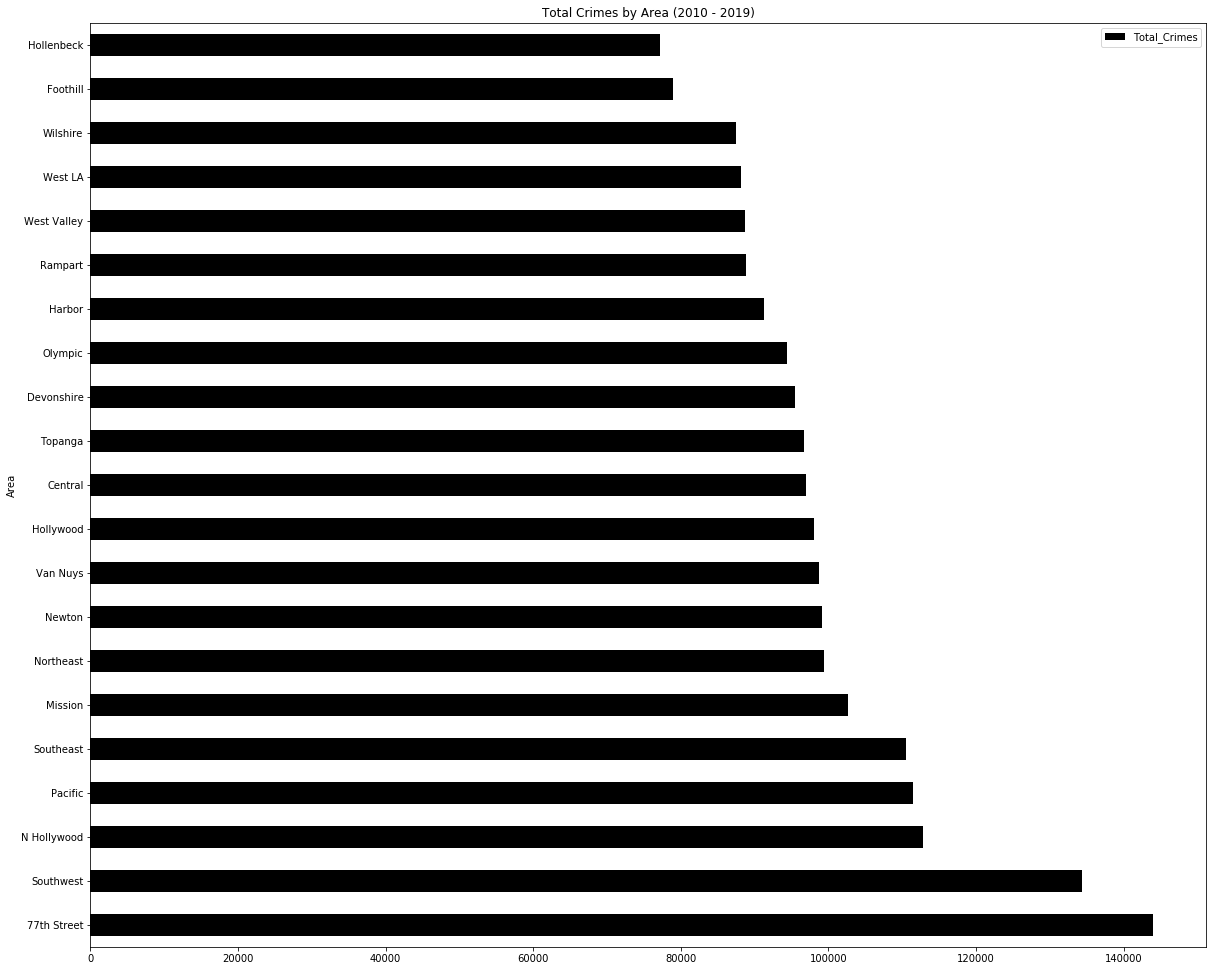

In [20]:
total_crimes_df.plot.barh(figsize=(20,17), color='black')
plt.title("Total Crimes by Area (2010 - 2019)")
plt.savefig("static/images/plot_total_crimes_barh.png", bbox_inches='tight') 
plt.show()

### Total proportional crime by area

In [21]:
# Create a pivot table to summarize the counts of each event
alldata_areas_crime = pd.pivot_table(df_areas_crimes, values='Year', index=['Area'], columns=['Crime_Desc'], aggfunc='count')
alldata_areas_crime = alldata_areas_crime.fillna(0)
alldata_areas_crime

Crime_Desc,ABORTION/ILLEGAL,ARSON,ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",ATTEMPTED ROBBERY,BATTERY - SIMPLE ASSAULT,BATTERY ON A FIREFIGHTER,BATTERY POLICE (SIMPLE),BATTERY WITH SEXUAL CONTACT,"BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM",BIGAMY,BIKE - ATTEMPTED STOLEN,BIKE - STOLEN,BLOCKING DOOR INDUCTION CENTER,BOAT - STOLEN,BOMB SCARE,BRANDISH WEAPON,BRIBERY,"BUNCO, ATTEMPT","BUNCO, GRAND THEFT","BUNCO, PETTY THEFT",BURGLARY,BURGLARY FROM VEHICLE,"BURGLARY FROM VEHICLE, ATTEMPTED","BURGLARY, ATTEMPTED",CHILD ABANDONMENT,CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,CHILD ANNOYING (17YRS & UNDER),CHILD NEGLECT (SEE 300 W.I.C.),CHILD PORNOGRAPHY,CHILD STEALING,CONSPIRACY,CONTEMPT OF COURT,CONTRIBUTING,COUNTERFEIT,"CREDIT CARDS, FRAUD USE ($950 & UNDER","CREDIT CARDS, FRAUD USE ($950.01 & OVER)",CRIMINAL HOMICIDE,CRIMINAL THREATS - NO WEAPON DISPLAYED,CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER),CRUELTY TO ANIMALS,"DEFRAUDING INNKEEPER/THEFT OF SERVICES, $400 & UNDER","DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $400",DISCHARGE FIREARMS/SHOTS FIRED,DISHONEST EMPLOYEE - GRAND THEFT,DISHONEST EMPLOYEE - PETTY THEFT,DISHONEST EMPLOYEE ATTEMPTED THEFT,DISRUPT SCHOOL,DISTURBING THE PEACE,DOCUMENT FORGERY / STOLEN FELONY,DOCUMENT WORTHLESS ($200 & UNDER),DOCUMENT WORTHLESS ($200.01 & OVER),DRIVING WITHOUT OWNER CONSENT (DWOC),"DRUGS, TO A MINOR",DRUNK ROLL,DRUNK ROLL - ATTEMPT,"EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)","EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)",EXTORTION,FAILURE TO DISPERSE,FAILURE TO YIELD,FALSE IMPRISONMENT,FALSE POLICE REPORT,FIREARMS RESTRAINING ORDER (FIREARMS RO),FIREARMS TEMPORARY RESTRAINING ORDER (TEMP FIREARMS RO),GRAND THEFT / AUTO REPAIR,GRAND THEFT / INSURANCE FRAUD,HUMAN TRAFFICKING - COMMERCIAL SEX ACTS,HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE,ILLEGAL DUMPING,INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES),INCITING A RIOT,INDECENT EXPOSURE,INTIMATE PARTNER - AGGRAVATED ASSAULT,INTIMATE PARTNER - SIMPLE ASSAULT,KIDNAPPING,KIDNAPPING - GRAND ATTEMPT,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",LEWD CONDUCT,LEWD/LASCIVIOUS ACTS WITH CHILD,LYNCHING,LYNCHING - ATTEMPTED,"MANSLAUGHTER, NEGLIGENT",ORAL COPULATION,OTHER ASSAULT,OTHER MISCELLANEOUS CRIME,PANDERING,PEEPING TOM,PETTY THEFT - AUTO REPAIR,PICKPOCKET,"PICKPOCKET, ATTEMPT",PIMPING,PROWLER,PURSE SNATCHING,PURSE SNATCHING - ATTEMPT,"RAPE, ATTEMPTED","RAPE, FORCIBLE",RECKLESS DRIVING,"REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)",RESISTING ARREST,ROBBERY,"SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ",SEXUAL PENETRATION W/FOREIGN OBJECT,SHOPLIFTING - ATTEMPT,SHOPLIFTING - PETTY THEFT ($950 & UNDER),SHOPLIFTING-GRAND THEFT ($950.01 & OVER),SHOTS FIRED AT INHABITED DWELLING,"SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT",SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH,STALKING,TELEPHONE PROPERTY - DAMAGE,THEFT FROM MOTOR VEHICLE - ATTEMPT,THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER),THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),THEFT FROM PERSON - ATTEMPT,THEFT OF IDENTITY,THEFT PLAIN - ATTEMPT,THEFT PLAIN - PETTY ($950 & UNDER),"THEFT, COIN MACHINE - ATTEMPT","THEFT, COIN MACHINE - GRAND ($950.01 & OVER)","THEFT, COIN MACHINE - PETTY ($950 & UNDER)","THEFT, PERSON","THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD",THREATENING PHONE CALLS/LETTERS,THROWING OBJECT AT MOVING VEHICLE,TILL TAP - ATTEMPT,TILL TAP - GRAND THEFT ($950.01 & OVER),TILL TAP - PETTY ($950 & UNDER),TRAIN WRECKING,TRESPASSING,UNAUTHORIZED COMPUTER ACCESS,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)",VANDALISM - MISDEAMEANOR ($399 OR UNDER),VEHICLE - ATTEMPT STOLEN,"VEHICLE - MOTORIZED SCOOTERS, BICYCLES, AND WHEELCHAIRS",VEHICLE - STOLEN,VIOLATION OF COURT ORDER,VIOLATION OF RESTRAINING ORDER,VIOLATION OF TEMPORARY RESTRAINING ORDER,WEAPONS POSSESSION/BOMBING
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

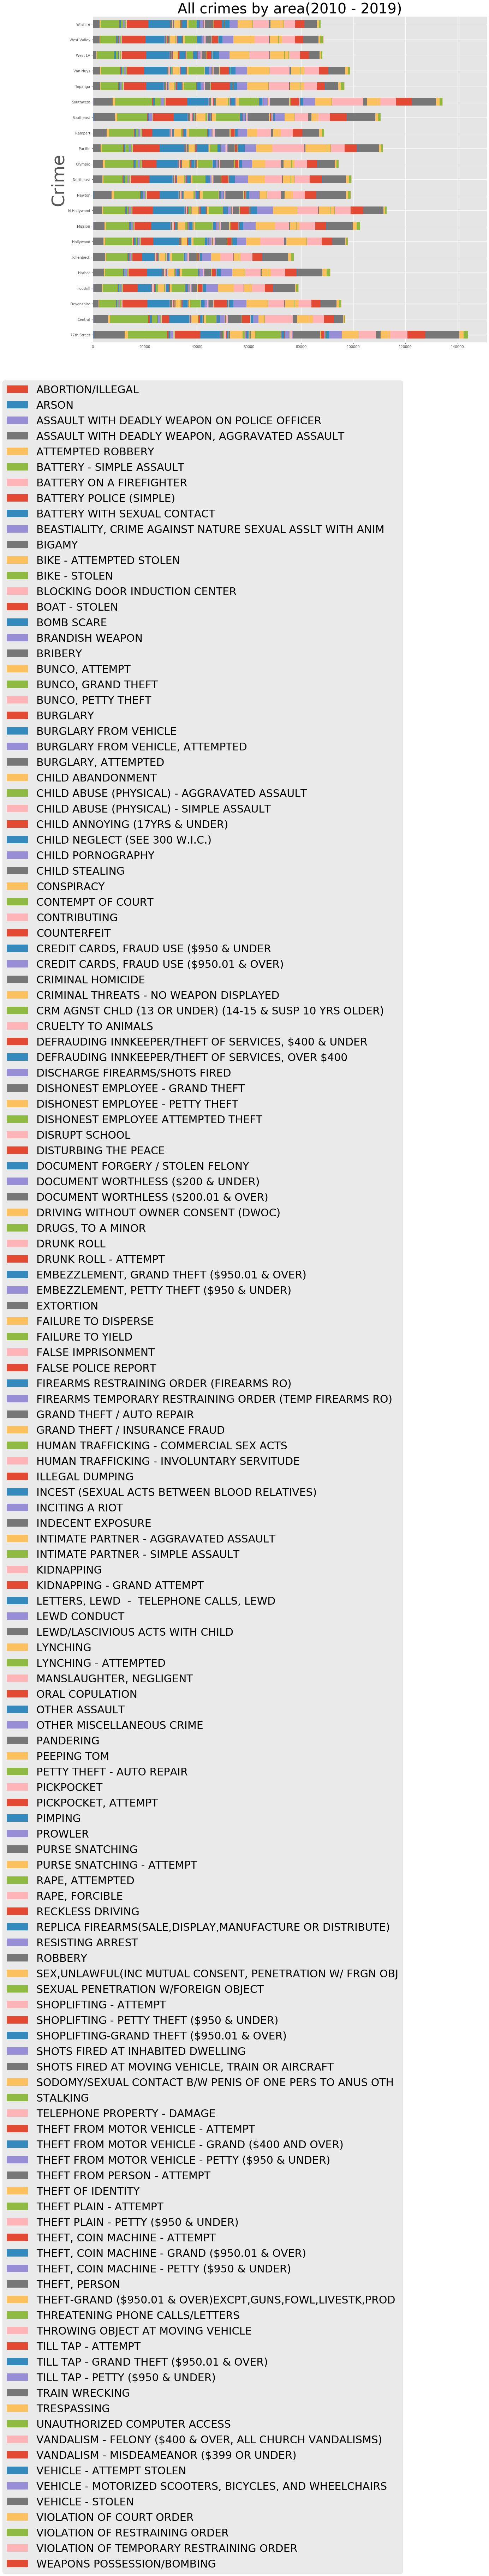

In [22]:
plt.style.use('ggplot')
alldata_areas_crime.plot.barh(stacked=True, figsize=(20,17))
plt.rcParams.update({'axes.titlesize': 40})
plt.rc('legend',**{'fontsize':30})
plt.ylabel("Crime", fontsize=50)
plt.legend(loc='upper right', bbox_to_anchor=(.8, -.1), ncol=1)
plt.title("All crimes by area(2010 - 2019)")
plt.savefig("static/images/plot_allgrimes_by_area_barh.png", bbox_inches='tight') 
plt.show()

### Victim Age

In [23]:
df_crimes[['Vict_Age']].describe().apply(lambda x: '%5f' % x, axis=1)

count    2094820.000000
mean          31.786129
std           20.632515
min           -9.000000
25%           20.000000
50%           32.000000
75%           46.000000
max          118.000000
dtype: object

In [24]:
# Minor subset to evaluate victim sex by age, but need to omit the category datatype from victim se
vict_age_sex_df = df_crimes[["Vict_Sex", "Vict_Age"]]

In [25]:
# Use a boolean to filter dataset to just M or F victims
vict_age_sex_df = vict_age_sex_df[(df_crimes.Vict_Sex == 'M') | (vict_age_sex_df.Vict_Sex == 'F')]

In [26]:
# Convert category column to string in order to just plot male and female
# Otherwise, the x axis will display all categories in this column
vict_age_sex_df['Vict_Sex'] = vict_age_sex_df['Vict_Sex'].astype(str)

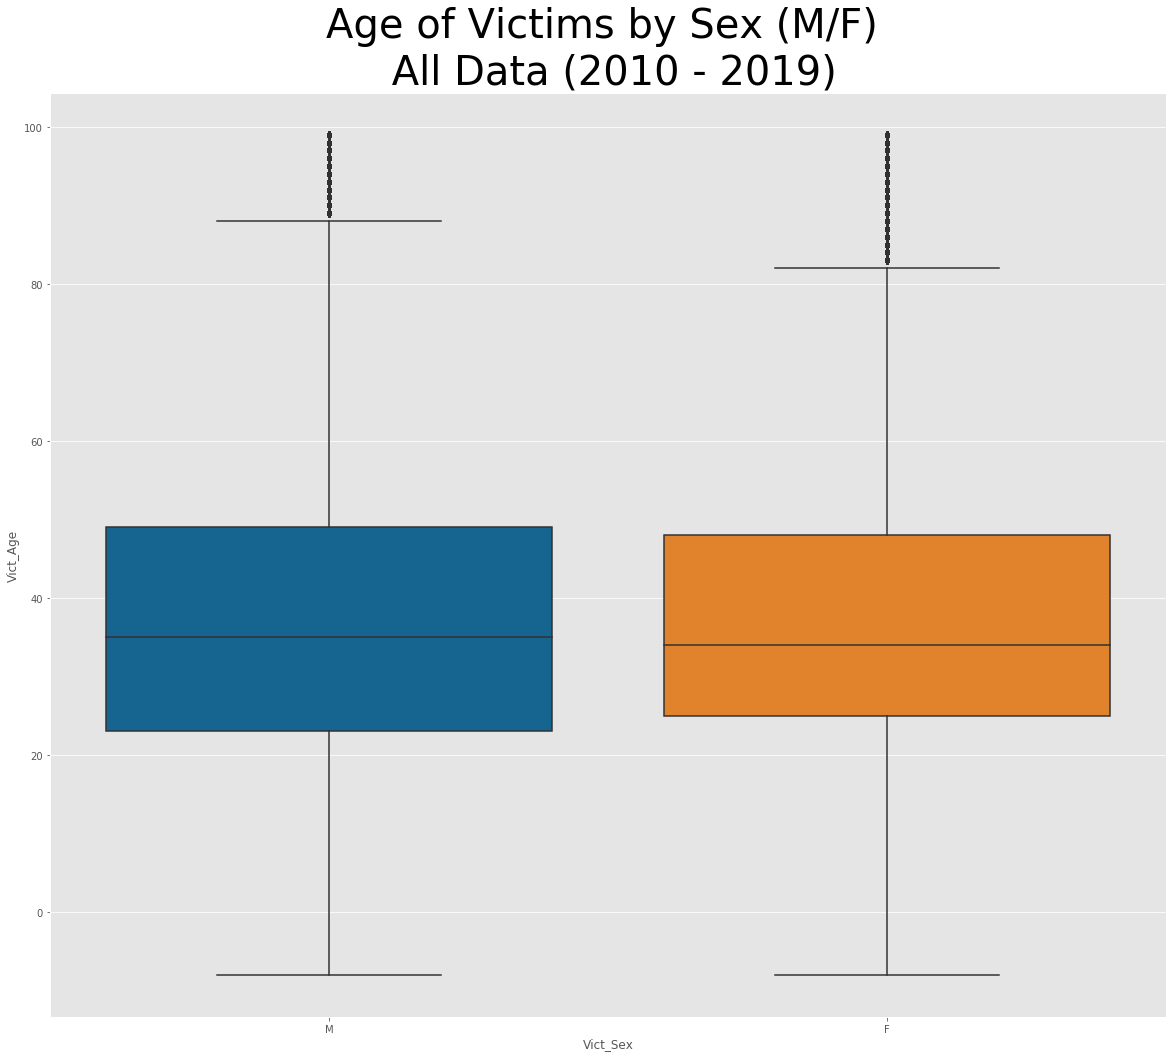

In [27]:
plt.figure(figsize=(20,17))
plt.style.use('tableau-colorblind10')
ax = sns.boxplot(x="Vict_Sex", y="Vict_Age", data=vict_age_sex_df)
plt.title("Age of Victims by Sex (M/F) \n All Data (2010 - 2019)")
plt.savefig("static/images/plot_age_sex_distribution_alldata.png", bbox_inches='tight') 
plt.show()

### Victim Descent

In [28]:
AD_Top10_Victim_groups = df_crimes['Vict_Desc'].value_counts(ascending=False)
top10_vict_list = list(AD_Top10_Victim_groups.index.values.tolist())[0:10]

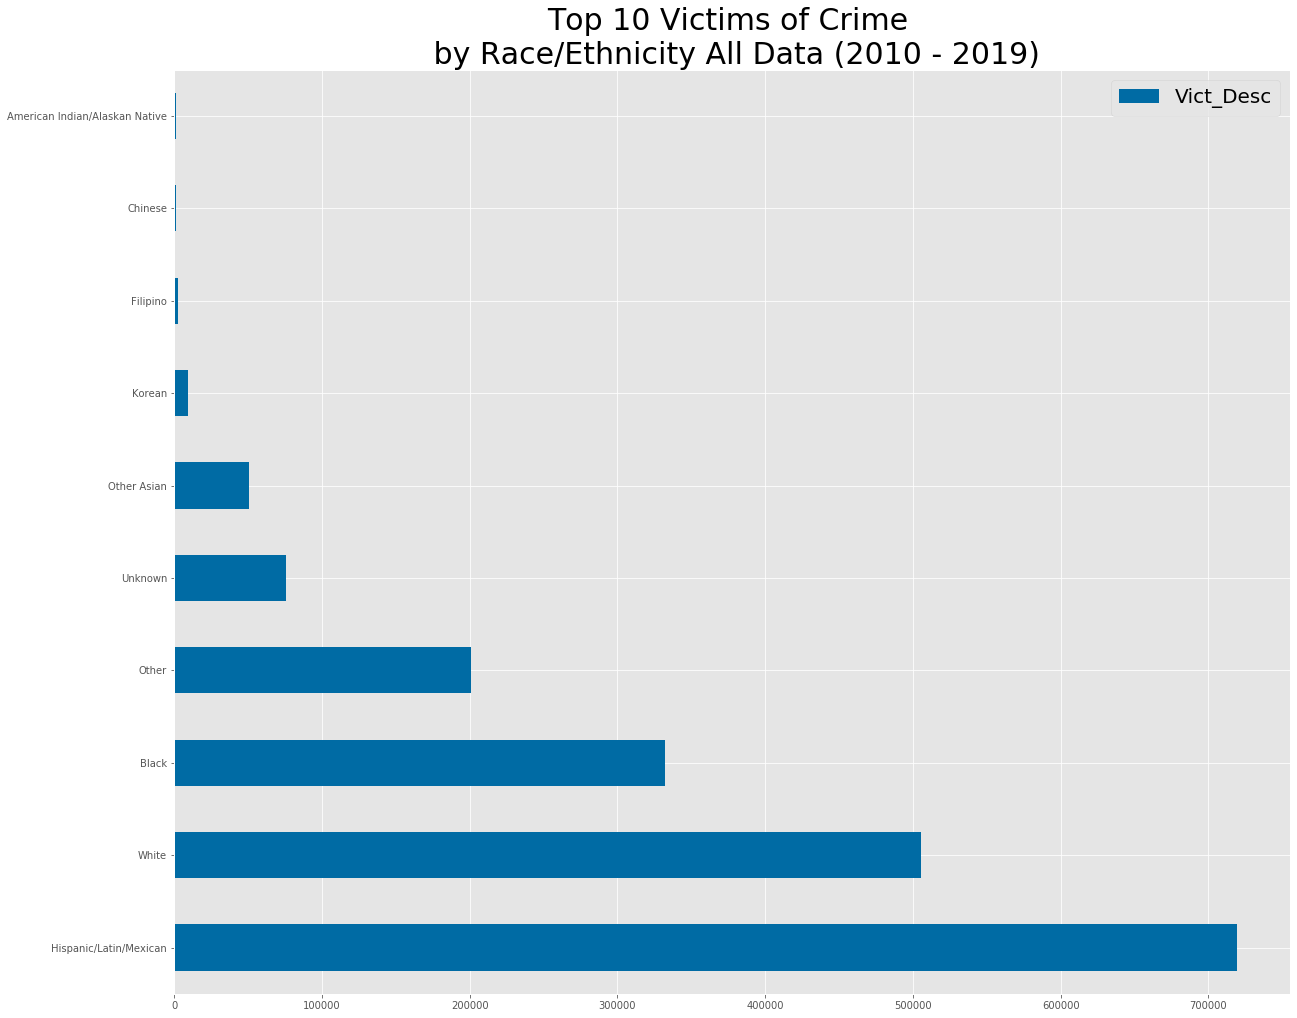

In [29]:
plt.style.use('tableau-colorblind10')
AD_Top10_Victim_groups[0:10].plot.barh(stacked=False, figsize=(20,17))
plt.rcParams.update({'axes.titlesize': 30})
plt.rcParams.update({'axes.labelsize': 30})
plt.rcParams.update({'ytick.labelsize': 30})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rc('legend',**{'fontsize':20})
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
plt.title("Top 10 Victims of Crime \n by Race/Ethnicity All Data (2010 - 2019)")
plt.savefig("static/images/plot_top10_victDesc_allyears_barh.png", bbox_inches='tight') 
plt.show()

### Top 10 weapons and top 10 crimes reported between 2010 - 2019

In [35]:
# Top 10 crimes reported
all_data_top10_crimes = df_crimes['Crime_Code'].value_counts()
top_10_crimes = list(all_data_top10_crimes.index.values.tolist())[0:10]

In [46]:
# Percent of crime codes with more than 100 incidents between 2010-2018
per_higher_100 = len(all_data_top10_crimes[all_data_top10_crimes >=100])/149
print(f'{round(per_higher_100, 1)*100}% of crime codes in dataset had more than 100 incidents')

70.0% of crime codes in dataset had more than 100 incidents


In [ ]:
# Top 10 crimes described in data
all_data_top10_crimes_desc = df_crimes['Crime_Desc'].value_counts()
top_10_crimes_descs = list(all_data_top10_crimes_desc.index.values.tolist())[0:10]

In [ ]:
# Top 10 weapons reported
all_data_top10_weapons = df_crimes['Weapon_Desc'].value_counts()
top_10_weapons = list(all_data_top10_weapons.index.values.tolist())[0:10]

### Plot the top 10 crimes reported for all data in dataset
 - omitted any incidents missing 'Date Rptd', 'Crm Cd 1', 'Weapon Desc'

In [ ]:
plt.style.use('tableau-colorblind10')
all_data_top10_crimes_desc[0:10].plot.barh(stacked=False, figsize=(20,17))
plt.rcParams.update({'axes.titlesize': 30})
plt.rcParams.update({'axes.labelsize': 30})
plt.rcParams.update({'ytick.labelsize': 10})
plt.rcParams.update({'xtick.labelsize': 30})
plt.rc('legend',**{'fontsize':20})
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
plt.title("Top 10 Crimes Reported \n All Data (2010 - 2019)")
plt.savefig("static/images/plot_top10_crimedesc_allyears_barh.png", bbox_inches='tight') 
plt.show()

# SUBSET 3: FILTERED DATASET CONTAINS ONLY TOP WEAPON AND TOP CRIME INCIDENTS 2010 - 2019  
 - ORIGIN FROM SUBSET df_crimes

### Filter dataframe to only include top 10 crimes
 - start with the df_crimes dataframe

In [ ]:
# filter data for incidents that contain top 10 crimes
alldata_top10_crimes = []
for value in top_10_crimes:
    temp_df = df_crimes.loc[df_crimes['Crime_Code'] == value]
    alldata_top10_crimes.append(temp_df)

In [ ]:
# Make a dataframe of the top 10 crimes for all data (subset)
top10_crimes_df = pd.concat(alldata_top10_crimes)

### Filter dataframe to only include top 10 weapons
 - use the filtered top10_crimes_df

In [ ]:
# filter data for incidents that contain top 10 weapons
top10_alldata = []
for value in top_10_weapons:
    temp_df = top10_crimes_df.loc[top10_crimes_df['Weapon_Desc'] == value]
    top10_alldata.append(temp_df)

In [ ]:
# Make a dataframe of the top 10 crimes with the top 10 weapons for all data (subset)
top10_alldata_df = pd.concat(top10_alldata)

In [ ]:
crime_code_dict = {230: 'Assault with Deadly Wapon', 310: 'Burglary', 330 : '(Burg from Vehicle)', 354 :'Theft of identity', 440 : 'Theft - $950 & under', 510 : 'Stolen Vehicle', 624: 'Battery - misdemeanor', 626: 'Spousal/Cohab Abuse - Simple Assault', 740: 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA)', 745: 'VANDALISM - MISDEAMEANOR ($399 OR UNDER)'}

In [ ]:
top10_alldata_df['Crime_Code'].replace(crime_code_dict, inplace=True)

In [ ]:
# Create a pivot table to summarize the counts of each event
top10_alldatatable = pd.pivot_table(top10_alldata_df, values='Year', index=['Crime_Code'], columns=['Weapon_Desc'], aggfunc='count')
# Replace all nan values with 0
top10_alldatatable.fillna(0)

In [ ]:
# Rename the index column to Crimes
top10_alldatatable.index.names = ['Crimes']

In [ ]:
# Sort values by the strong arm column
top10_alldatatable = top10_alldatatable.sort_values("STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",ascending=False)

In [ ]:
plt.style.use('ggplot')
top10_alldatatable.plot.barh(stacked=True, figsize=(20,17))
plt.rcParams.update({'axes.titlesize': 40})
plt.rc('legend',**{'fontsize':30})
plt.ylabel("Crime", fontsize=50)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
plt.title("Top 10 Crimes By Weapon \n All Data (2010 - 2019)")
plt.savefig("static/images/plot_top10_categories_allyears_barh.png", bbox_inches='tight') 
plt.show()

### Pivot table for area and types of crime

In [ ]:
# Create a pivot table to summarize the counts of each event
top10_alldata_areas = pd.pivot_table(top10_alldata_df, values='Year', index=['Area'], columns=['Crime_Code'], aggfunc='count')
top10_alldata_areas.fillna(0)

In [ ]:
# Then delete that column, and then plot. I have to delete the total column otherwise it will screw up the stacked bar chart.
top10_alldata_areas["Total"] = top10_alldata_areas.sum(axis=1)
top10_alldata_areas = top10_alldata_areas.sort_values("Total",ascending=False)
top10_alldata_areas = top10_alldata_areas.drop(columns=["Total"], axis =1)

In [ ]:
plt.style.use('tableau-colorblind10')
top10_alldata_areas.plot.barh(stacked=True, figsize=(20,17))
plt.rcParams.update({'axes.titlesize': 30})
plt.rcParams.update({'axes.labelsize': 30})
plt.rcParams.update({'ytick.labelsize': 25})
plt.rcParams.update({'xtick.labelsize': 30})
plt.ylabel("Area", fontsize=20)
plt.rc('legend',**{'fontsize':20})
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
plt.title("Top 10 Crimes Reported \n All Data (2010 - 2019)")
plt.savefig("static/images/plot_top10_categories_crime_by_area_allyears_barh.png", bbox_inches='tight') 
plt.show()

# SUBSET 4: FILTERED DATASET 2010 - 2018
 - ORIGIN FROM SUBSET df_crimes

In [ ]:
# Filter out 2019 data (as it is incomplete in this data set)
end_year = '2019-01-01'
mask = df_crimes['Date'] < end_year
df_crimes_2010_2018 = df_crimes.loc[mask]
df_weapons_2010_2018 = df_weapon_crimes.loc[mask]

### Determine top 10 crimes for incidents between 2010 - 2018 unfiltered by weapon

In [ ]:
top10_to_2018_crimes = df_crimes_2010_2018['Crime_Desc'].value_counts()
top10_all_crimes = pd.DataFrame(top10_to_2018_crimes).head(10)
top10_all_crimes = top10_all_crimes.reset_index()
top10_all_crimes.columns = ['Crime', 'Totals']
top10_all_crimes

## What are the top 10 weapons reported in crimes

In [ ]:
### Determine top 10 crimes for incidents between 2010 - 2018 filtered by weapon

In [ ]:
# Total number of unique crimes
num_weapons = len(df_weapons_2010_2018["Crime_Desc"].unique())
print(f"The total number of crimes involving weapons recorded in dataset is {num_weapons}")

In [ ]:
top10_to_2018_weapons_in_crimes = df_weapons_2010_2018['Crime_Desc'].value_counts()
top10_crime_weapons = pd.DataFrame(top10_to_2018_weapons_in_crimes).head(10)
top10_crime_weapons = top10_crime_weapons.reset_index()
top10_crime_weapons.columns = ["Crimes", 'Totals']
top10_crime_weapons

In [ ]:
# Total number of unique weapons
num_weapons = len(df_weapons_2010_2018["Weapon_Desc"].unique())
print(f"The total number of weapons recorded in dataset is {num_weapons}")

In [ ]:
top10_to_2018_weapon_crimes = df_weapons_2010_2018['Weapon_Desc'].value_counts()
top10_weapon_crimes = pd.DataFrame(top10_to_2018_weapon_crimes).head(10)
top10_weapon_crimes = top10_weapon_crimes.reset_index()
top10_weapon_crimes.columns = ["Weapons", 'Totals']
top10_weapon_crimes

## How have the top 10 weapons reported in crimes changed over time
 - Create a dataframe that has grouped data by weapon, and then aggregate by year, and count the number of events within each weapon category
 - generate line plots for each weapon category

In [ ]:
labels = np.sort(df_weapons_2010_2018['Year'].unique()) # X axis labels
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (10,10))
rects1 = ax.bar(x - width/2, df_crimes_2010_2018.groupby('Year')['Crime_Code'].count().values, width, label='All Crimes')
rects2 = ax.bar(x + width/2, df_weapons_2010_2018.groupby('Year')['Crime_Code'].count().values, width, label='Weapon Related Crimes')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Annual Totals')
ax.set_title('Los Angeles Crime Incidents between 2010-2018')
plt.rcParams.update({'axes.titlesize': 20})
plt.rcParams.update({'axes.labelsize': 20})
# plt.rcParams.update({'ytick.labelsize': 10})
plt.rcParams.update({'xtick.labelsize': 20})
plt.ylabel("Counts", fontsize=20)
plt.rc('legend',**{'fontsize':10})
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
# Move legend to the top of the plot so it doesn't obscure figure
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)
plt.savefig("static/images/plot_totalCrime_vs_weaponCrime_bar.png", bbox_inches='tight')
plt.show()

### Prepare data for plotting
 - Filter the all_weapons_df to only the top 10 weapons reported in crimes
 - use the top_10_weapons list generated above and convert that into an array
 - then use a for loop to filter the database and then create a new dataframe with just 
 - the top 10 weapons

In [ ]:
# Group dataframe by weapon, and downsample to just show years
grouped = df_weapons_2010_2018.groupby('Weapon_Desc').resample('Y', on = "Date").count()
# Group by the crime_code column, but the values in each column are the same, 
# as it is aggregated by .count()
grouped_df = grouped[['Crime_Code']]
# Then convert index values to columns using the .reset_index()
all_weapons_df = grouped_df.reset_index()
# Reduce the date column to just the year (omit the month and last day of the month)
all_weapons_df['Year'] = all_weapons_df['Date'].dt.year
# Rename columns
all_weapons_df.rename(columns={'Weapon_Desc': 'Weapon','Date_Reported':'Year', 'Crime_Code': 'Annual_Total'}, inplace=True)

In [ ]:
# Convert top_10_weapons list into an array
array = np.asarray(top_10_weapons)

In [ ]:
# Create a dataframe that only contains the top 10 weapons
frames = []
for value in array:
    temp_df = all_weapons_df.loc[all_weapons_df["Weapon"] == value]
    frames.append(temp_df)

In [ ]:
# Concatenate the filtered dataframe
top10weapons = pd.concat(frames, axis=0)
# Convert the Weapon column from category to object, otherwise, the plots will contain
# every weapon category, when we just want the top 10 in the array generated above.
top10weapons = top10weapons.astype({'Weapon': 'str'})

### Display weapon related crimes in LA between 2010 - 2018 (Aggregated Plot)

### Display weapon related crimes in LA between 2010 - 2018 (Individual Plots)

In [ ]:
fig = plt.figure(figsize=(35,30))
fig.subplots_adjust(hspace=1, wspace=0.2)
for c,num in zip(array, range(1,11)):
    df0=top10weapons[top10weapons['Weapon']==c]
    ax = fig.add_subplot(5,5, num)
    ax.plot(df0['Year'], df0['Annual_Total'])
    ax.set_title(c)

plt.tight_layout()
plt.savefig("static/images/top_weapons_line_plots.png", bbox_inches='tight')
plt.show()

## What are general features of the all victims (2010-2019)
 - Age
 - Sex
 - Age by Sex

### Descriptive statistics of ALL victim ages
 - Create a subset that only include the Victim Age

In [ ]:
# Descriptive statistics for victim age for all sexes
# This includes the categories we omit later (non male or female)
df_weapons_2010_2018[['Vict_Age']].describe()

In [ ]:
# Use a boolean to filter dataset to just M or F victims
vict_age_sex_2010_2018 = df_weapons_2010_2018[(df_weapons_2010_2018.Vict_Sex == 'M') | (df_weapons_2010_2018.Vict_Sex == 'F')]
vict_age_sex_2010_2018['Vict_Sex'].replace({'F':'Female', 'M':'Male'}, inplace=True)

In [ ]:
plt.figure(figsize=(15,10))
plt.style.use('tableau-colorblind10')
ax = sns.boxplot(x="Vict_Sex", y="Vict_Age", data=vict_age_sex_2010_2018)
plt.title("Age of Victims by Sex (F/M) \n Data Reported (2010 - 2018)")
plt.ylabel("Age")
plt.xlabel("Victim Sex")
plt.savefig("static/images/plot_age_sex_boxplot_2010_2018.png", bbox_inches='tight') 
plt.show()

### Descriptive statistics of victim ages by Sex

In [ ]:
# Find out what is the age descriptive statistics by sex
vict_age_by_sex = df_weapons_2010_2018.groupby('Vict_Sex')['Vict_Age'].describe()
# Drop non M or F categories
vic_age_by_sex = vict_age_by_sex.drop(['H', 'N', 'X', '-'])
vic_age_by_sex

## Visualize distribution of the ages of victims in weapon related crimes

In [ ]:
# Plot all the victim age for all victims
sns.distplot(df_weapons_2010_2018[['Vict_Age']], bins=10, kde=False).set_title('Ages of Crime Victims \n in LA County (2010 - Present)')
plt.savefig("static/images/plot_vict_age_all_histogram.png", bbox_inches='tight')
plt.show()

## Visualize distribution of the ages of victims of weapon related crimes filtered for either Female or Male.

In [ ]:
# Subset data by victim sex for only known sexes
all_F_age_data = df_weapons_2010_2018.loc[df_weapons_2010_2018["Vict_Sex"] == "F"][['Vict_Age']]
# array with the female data
female_data = all_F_age_data['Vict_Age'].values
all_M_age_data = df_weapons_2010_2018.loc[df_weapons_2010_2018["Vict_Sex"] == "M"][['Vict_Age']]
# array with the male data
male_data = all_M_age_data['Vict_Age'].values

In [ ]:
# Plot all the victim age for all victims
fig1, axs1 = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20, 10))
sns.distplot(all_F_age_data, bins=10, kde=False, color='tab:blue', ax=axs1[0]).set_title('Ages of Female Crime Victims \n in LA County (2010 - 2018)')
sns.distplot(all_M_age_data, bins=10, kde=False, color='tab:blue', ax=axs1[1]).set_title('Ages of Male Crime Victims \n in LA County (2010 - 2018)')
fig1.savefig("static/images/plot_vict_age_by_sex_histograms.png", bbox_inches='tight')
plt.show()

## Determine if there is a difference in the mean number of crimes between male and female

### Test for normality and equal variance
 - cannot use a shapiro-wilk test because the p value will not be accurate with N > 5000

In [ ]:
import scipy.stats as stats
left = -1.8
fig = plt.figure(figsize=(8,8))

# qq plot for female victims
ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(female_data, line='s', ax=ax)
top = ax.get_ylim()[1] * 0.75
ax.title.set_text('Ages of Female Victims QQ Plot')
plt.yticks(color='black')
plt.xticks(color='black')
plt.ylabel('Sample Quantiles', color='black')
plt.xlabel('Theoretical Quantiles', color='black')

# qq plot for male victims
ax = fig.add_subplot(2, 2, 3)
sm.graphics.qqplot(male_data, line='s', ax=ax)
top = ax.get_ylim()[1] * 0.75
ax.title.set_text("Ages of Male Victims QQ Plot")
plt.yticks(color='black')
plt.xticks(color='black')
plt.ylabel('Sample Quantiles', color='black')
plt.xlabel('Theoretical Quantiles', color='black')

fig.tight_layout()
fig.savefig("static/images/plot_vict_age_by_sex_qq_plots.png", bbox_inches='tight')
plt.show()

In [ ]:
# Test for equal variance
# scipy.stats.bartlett because I know the samples are normally distributed
barlette_result = stats.bartlett(female_data, male_data)
if barlette_result[1] >= 0.05:
    print("Do not reject the null hypothesis, all the input samples are from populations with equal variances.")
else:
    print("Reject the null hypothesis, the samples do not have equal variance")

### Welch’s t-test for two indepedent samples

In [ ]:
vict_sex_t_test = stats.ttest_ind(female_data,male_data, equal_var=False)
if vict_sex_t_test[1] >= 0.05:
    print(f"The p values is {vict_sex_t_test[1]}. Do not reject the null hypothesis.")
else:
    print(f"The p values is {vict_sex_t_test[1]}. Reject the null hypothesis, the samples significantly different.")

## <font color='red'>There is significant difference in the mean age of victims by sex.</font>

## Explore the ethnic/racial makeup of victims of weapon related crimes

In [ ]:
# Get the top 10 victims of weapon related crimes by their descendant category
top10_vict_desc = df_weapons_2010_2018['Vict_Desc'].value_counts()[0:10]
top10_vict_desc_df = pd.DataFrame(top10_vict_desc)
top10_vict_desc_df.columns=["Total_Count"]
top10_vict_desc_df

### Prepare victim ethnic data for visualization

In [ ]:
# Make a list of the top 10 victim descent
# This will be the axist category for the bar plot
desc_cat = list(top10_vict_desc_df.index.values.tolist()) 

In [ ]:
# Prepare a list of the number of victims per descent category (in descending order)
# This will be the height value for the bar plot
vic_desc_values = top10_vict_desc.values.tolist()

In [ ]:
# plt.rcdefaults()
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,10))
plt.rc('axes', titlesize=22)
plt.rc('ytick', labelsize=22)
plt.yticks(color='black')
plt.xticks(color='black')
plt.xlabel('Total Counts', fontsize=20, color='black')

# Example data
y = desc_cat
y_pos = np.arange(len(desc_cat))

ax.barh(y_pos, vic_desc_values, align='center', color='blue', alpha = 0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(y)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Total Count')
ax.set_title("Total Victims in Weapons Related Crimes (2010 - 2018)")
plt.savefig("static/images/plot_all_crimes_by_vict_desc.png", bbox_inches='tight') 

plt.show()

## <Font color='red'>The majority of victims of weapon related crimes are Hispanic, Black, and White individuals</Font>

## In what crimes were the weapons used?
 - Data: List of the top 10 crimes by count: wc_top_10_df (need to get the index) 
 - Filter weapon_df by the names on this list
 - Aggregate data

In [ ]:
# Step 1: Create a dataframe that contains only a subset of columns
prep_crime_df_1 = weapon_df[['Date_Reported', 'Crime_Code', 'Weapon_Desc']].copy()

In [ ]:
# Step 2: Filter out rows that do not contain the top to crime codes

In [ ]:
# Drop the month and day in the year column
top10crimes_by_weapon['Year'] = top10crimes_by_weapon['Year'].dt.year

In [ ]:
# Extract the index (crime codes)
top_10_crime_codes = list(df_weapons_2010_2018['Crime_Code'].value_counts()[0:9].index.values.tolist())
crime_array = np.asarray(top_10_crime_codes)

In [ ]:
# Create a dataframe that only contains the top 10 weapons
crime_frames = []
for value in crime_array:
    temp_df = df_weapons_2010_2018.loc[df_weapons_2010_2018["Crime_Code"] == value]
    crime_frames.append(temp_df)

In [ ]:
# Concatenate the filtered dataframe
top10crimes_by_weapon = pd.concat(crime_frames, axis=0)

In [ ]:
# Rename columns
top10crimes_by_weapon.rename(columns={'Weapon_Desc': 'Weapon'}, inplace=True)

In [ ]:
top10crimes_by_weapon.columns

In [ ]:
# Convert the Weapon column from category to object, otherwise, the plots will contain
# every weapon category, when we just want the top 10 in the array generated above.
top10crimes_by_weapon = top10crimes_by_weapon.astype({'Weapon': 'str'})

In [ ]:
# Dictionary of crime codes and their text description (ucr reporting dictionary available online)
crimes_dict = {624 : 'Battery - misdemeanor', 626 : 'Spousal/Cohab Abuse - Simple Assault', 230 : 'Assault with a Deadly Weapon', 210 : 'Robbery', 930 : 'Criminal Threats', 236 : 'Spousal beating', 761 : 'Brandishing', 220 : 'Robbery - attempted', 310 :  'Assault on Firefighter or Peace Officer With Deadly Weapon'}

In [ ]:
# Replace crime codes with crime description
top10crimes_by_weapon['Crime_Code'].replace(crimes_dict, inplace= True)

### Filter database by top 10 weapon! Otherwise we get everything
 - Use the array list that contains the top 10 weapons
 - Use the top10crimes_by_weapon dataframe

In [ ]:
# Create a dataframe that only contains the top 10 weapons
new_frames = []
for value in array:
    temp_df = top10crimes_by_weapon.loc[top10crimes_by_weapon["Weapon"] == value]
    new_frames.append(temp_df)

In [ ]:
# Concatenate the filtered dataframe
top10crimes_weapons_df = pd.concat(new_frames, axis=0)

In [ ]:
# Create a pivot table to summarize the counts of each event
weapon_crime_table = pd.pivot_table(top10crimes_weapons_df, values='Year', index=['Crime_Code'], columns=['Weapon'], aggfunc='count')
weapon_crime_table

In [ ]:
# Create a total column that adds all values from all other columns
weapon_crime_table["Total"] = weapon_crime_table.sum(axis=1)

In [ ]:
# Sort rows by totals column
weapon_crime_table = weapon_crime_table.sort_values("Total",ascending=False)

In [ ]:
# Drop totals now that it has been sorted
weapon_crime_table.drop(columns=["Total"], axis =1)

In [ ]:
# Plot
plt.style.use('tableau-colorblind10')
weapon_crime_table.plot.barh(stacked=True, figsize=(40,30))
plt.rc('legend',**{'fontsize':40})
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
plt.ylabel('Crimes', color='black')
plt.xlabel('Totals', color='black')
plt.yticks(color='black', fontsize=35)
plt.xticks(color='black', fontsize=35)
plt.title("Proportion of Weapons Reported \n in Top 10 Crimes (2010 - 2018)", fontsize=50)
plt.savefig("static/images/plot_weapon_crime_pivot_barh.png", bbox_inches='tight') 
plt.show()

## Get data for leaflet javascript mapping
 - Entire dataset from 2010 - 2019 that is filtered by the top ten crimes that involve weapons
 - The file that will be saved for website will be 2019 only

In [ ]:
# Create a dataframe that only contains the top 10 weapons
leaflet_data = []
for value in crime_array:
    temp_df = df_crimes.loc[df_crimes["Crime_Code"] == value]
    leaflet_data.append(temp_df)

In [ ]:
# Create subset dataframe with to 10 crimes
crime_location_df = pd.concat(leaflet_data, axis=0, ignore_index = True)

In [ ]:
# Replace crime codes with text description
crime_location_df['Crime_Code'].replace(crimes_dict, inplace=True)

In [ ]:
_2019_crime_lo_df = crime_location_df.loc[crime_location_df['Year'] == 2019]

In [ ]:
_2019_crime_lo_df.to_csv("static/js/crime_map_data.csv", index=False)

## What areas have the highest incidents of the weapon related crimes for all data

In [ ]:
# Group crimes by area and count events per area
area_crimes = crime_location_df.groupby("Area")["Crime_Code"].agg('count')

In [ ]:
# Convert 
area_crime_df = pd.DataFrame(area_crimes)
area_crime_df.columns = ["Total Crimes"]

In [ ]:
area_crime_df = area_crime_df.sort_values("Total Crimes",ascending=False)

In [ ]:
# This has been filtered for only 10 of the top crimes
# These crimes are associated with weapon usage
area_crime_df.plot.barh(figsize=(20,17))
plt.title("Totals Crimes that Involve Weapons by Area (2010 - 2019)")
plt.savefig("static/images/plot_total_crime_area_unstacked_barh.png", bbox_inches='tight') 
plt.show()

### Create a pivot table for areas and count all the crimes

In [ ]:
# Create a pivot table to summarize the counts of each event in an area
area_crime_table = pd.pivot_table(crime_location_df, values='Year', index=['Area'], columns=['Crime_Code'], aggfunc='count')

In [ ]:
# Sort values before creating a proportional horizontal bar chart.  Will create a totals column, sort by that column
# Then delete that column, and then plot. I have to delete the total column otherwise it will screw up the stacked bar chart.
area_crime_table["Total"] = area_crime_table.sum(axis=1)
area_crime_table = area_crime_table.sort_values("Total",ascending=False)
area_crime_table = area_crime_table.drop(columns=["Total"], axis =1)

### Plot the top crimes that involve weapons by area for 2010 - 2019

In [ ]:
plt.style.use('tableau-colorblind10')
area_crime_table.plot.barh(stacked=True, figsize=(20,17))
plt.rcParams.update({'axes.titlesize': 30})
plt.rcParams.update({'axes.labelsize': 40})
plt.rcParams.update({'ytick.labelsize': 40})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rc('legend',**{'fontsize':20})
plt.legend(loc='upper right', bbox_to_anchor=(1.65, 1), ncol=1)
plt.title("Proportion of Crimes Reported (2010 - 2019)")
plt.savefig("static/images/plot_crime_area_pivot_barh.png", bbox_inches='tight') 
plt.show()